# Node Embeddings using Stellargraph | Cora

***Links***
* Keras, Inconsistent behavior when using model.predict for accessing intermediate layers output with spektral GCN - https://stackoverflow.com/questions/63731349/keras-inconsistent-behavior-when-using-model-predict-for-accessing-intermediate
* TSNE | Stellargraph - https://stellargraph.readthedocs.io/en/stable/demos/node-classification/gcn-node-classification.html
* Cora Stellargraph GCN Demo - https://stellargraph.readthedocs.io/en/latest/demos/node-classification/gcn-node-classification.html

In [2]:
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator, GraphSAGENodeGenerator 
from stellargraph.layer import GCN, GAT, GraphSAGE
from sklearn.manifold import TSNE

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt

In [3]:
dataset = sg.datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load()

In [4]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


In [5]:
node_subjects.value_counts().to_frame()

,subject
Neural_Networks,818
Probabilistic_Methods,426
Genetic_Algorithms,418
Theory,351
Case_Based,298
Reinforcement_Learning,217
Rule_Learning,180


In [7]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=140, test_size=None, stratify=node_subjects
)
val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=500, test_size=None, stratify=test_subjects
)

In [8]:
train_subjects.value_counts().to_frame()

,subject
Neural_Networks,42
Genetic_Algorithms,22
Probabilistic_Methods,22
Theory,18
Case_Based,16
Reinforcement_Learning,11
Rule_Learning,9


In [9]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)

In [10]:
batch_size = 50
num_samples = [10, 5]

generator = GraphSAGENodeGenerator(G,  batch_size, num_samples)

train_gen = generator.flow(train_subjects.index, train_targets)

In [11]:
a = G.to_adjacency_matrix().toarray()

In [12]:
a.shape

(2708, 2708)

In [14]:
generator

In [13]:
train_targets

array([[0, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0,

In [ ]:
stellargraph - customisation limited (simple)
* pytorch - classes, time, complex (simplicity)
spektral - heterogenous graphs

In [11]:
gat = GraphSAGE(
    layer_sizes=[32, 32], 
    activations=["selu", "selu"], 
    generator=generator, 
    # attn_heads=8, 
    # in_dropout=0.25, 
    # attn_dropout=0.25,
    kernel_initializer='lecun_normal',
)

x_inp, x_out = gat.in_out_tensors()

predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

In [12]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 10, 1433)]   0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 50, 1433)]   0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 1, 1433)]    0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 1, 10, 1433)  0           input_2[0][0]                    
______________________________________________________________________________________________

/home/vscode/.local/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [13]:
val_gen = generator.flow(val_subjects.index, val_targets)

In [14]:
from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor="val_acc", patience=30, restore_best_weights=True)

In [15]:
history = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback],
)

Epoch 1/200
3/3 - 2s - loss: 1.8548 - acc: 0.2571 - val_loss: 1.6925 - val_acc: 0.3580
Epoch 2/200
3/3 - 0s - loss: 1.3660 - acc: 0.7929 - val_loss: 1.5314 - val_acc: 0.6420
Epoch 3/200
3/3 - 0s - loss: 1.1651 - acc: 0.9714 - val_loss: 1.4747 - val_acc: 0.6980
Epoch 4/200
3/3 - 0s - loss: 1.0588 - acc: 0.9786 - val_loss: 1.3934 - val_acc: 0.7320
Epoch 5/200
3/3 - 0s - loss: 0.9591 - acc: 0.9929 - val_loss: 1.3346 - val_acc: 0.7080
Epoch 6/200
3/3 - 0s - loss: 0.8812 - acc: 0.9929 - val_loss: 1.2802 - val_acc: 0.7340
Epoch 7/200
3/3 - 0s - loss: 0.8131 - acc: 1.0000 - val_loss: 1.2512 - val_acc: 0.7320
Epoch 8/200
3/3 - 0s - loss: 0.7583 - acc: 1.0000 - val_loss: 1.2205 - val_acc: 0.7260
Epoch 9/200
3/3 - 0s - loss: 0.6996 - acc: 1.0000 - val_loss: 1.1964 - val_acc: 0.7160
Epoch 10/200
3/3 - 0s - loss: 0.6548 - acc: 1.0000 - val_loss: 1.1653 - val_acc: 0.7300
Epoch 11/200
3/3 - 0s - loss: 0.6083 - acc: 1.0000 - val_loss: 1.1341 - val_acc: 0.7320
Epoch 12/200
3/3 - 0s - loss: 0.5690 - ac

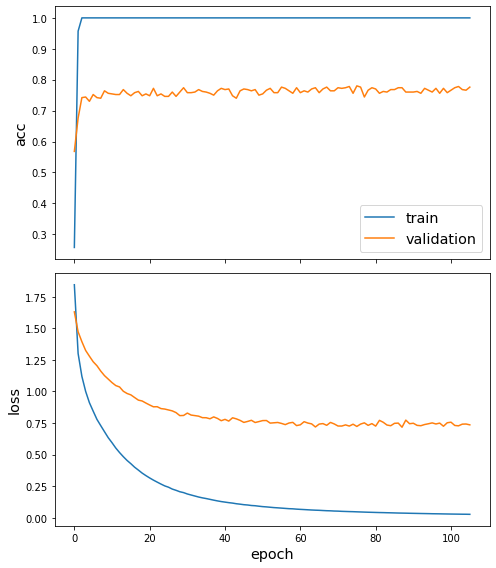

In [26]:
sg.utils.plot_history(history)

In [16]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [17]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

42/42 [==============================] - 1s 32ms/step - loss: 0.9793 - acc: 0.7074

Test Set Metrics:
	loss: 0.9793
	acc: 0.7074


In [18]:
all_nodes = node_subjects.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

In [30]:
all_predictions.shape

(2708, 7)

In [19]:
embedding_model = Model(inputs=x_inp, outputs=x_out)
emb = embedding_model.predict(all_gen)
emb.shape

(2708, 32)

In [32]:
emb

array([[ 0.1554485 ,  0.2916068 , -0.3297196 , ...,  0.06021297,
         0.19579731,  0.20983751],
       [ 0.2433639 ,  0.07534853, -0.08657062, ..., -0.00318025,
         0.26553175,  0.15882435],
       [ 0.05253627, -0.08579613,  0.23144546, ..., -0.16972403,
        -0.22038537, -0.26390663],
       ...,
       [-0.12416982, -0.0250777 ,  0.01433209, ...,  0.32741135,
        -0.0780175 , -0.14589942],
       [-0.05532082, -0.12413312,  0.0790175 , ...,  0.22505243,
         0.04735255, -0.250685  ],
       [ 0.10168675,  0.15367635, -0.13653822, ...,  0.07528725,
         0.0874093 ,  0.05660747]], dtype=float32)

In [33]:
transform = TSNE

In [34]:
X = emb.squeeze(0)
X.shape

ValueError: cannot select an axis to squeeze out which has size not equal to one

In [37]:
trans = transform(n_components=2)
X_reduced = trans.fit_transform(emb)
X_reduced.shape

(2708, 2)

[None,
 Text(0.5, 0, '$X_1$'),
 Text(0, 0.5, '$X_2$'),
 Text(0.5, 1.0, 'TSNE visualization of GraphSAGE embeddings for cora dataset (supervised)')]

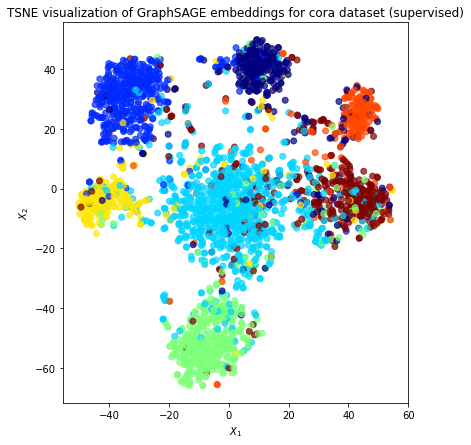

In [38]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=node_subjects.astype("category").cat.codes,
    cmap="jet",
    alpha=0.7,
)
ax.set(
    aspect="equal",
    xlabel="$X_1$",
    ylabel="$X_2$",
    title=f"{transform.__name__} visualization of GraphSAGE embeddings for cora dataset (supervised)",
)

[None,
 Text(0.5, 0, '$X_1$'),
 Text(0, 0.5, '$X_2$'),
 Text(0.5, 1.0, 'TSNE visualization of GAT embeddings for cora dataset')]

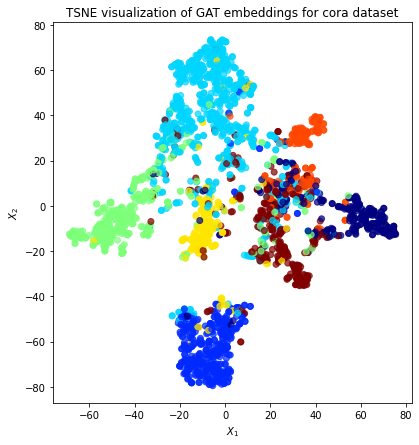

In [136]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=node_subjects.astype("category").cat.codes,
    cmap="jet",
    alpha=0.7,
)
ax.set(
    aspect="equal",
    xlabel="$X_1$",
    ylabel="$X_2$",
    title=f"{transform.__name__} visualization of GAT embeddings for cora dataset",
)

In [141]:
X.shape

(2708, 8)

In [1]:
import torch_geometric

In [2]:
torch_geometric.nn

<module 'torch_geometric.nn' from '/home/vscode/.local/lib/python3.6/site-packages/torch_geometric/nn/__init__.py'>

(2708, 1433)

In [29]:
G.node_features().shape

(2708, 1433)

In [30]:
# applying TSNE transform on only the raw features for nodes
transform = TSNE
trans = transform(n_components=2)
X_reduced = trans.fit_transform(G.node_features())
X_reduced.shape

(2708, 2)

[None,
 Text(0.5, 0, '$X_1$'),
 Text(0, 0.5, '$X_2$'),
 Text(0.5, 1.0, 'TSNE visualization of embeddings for the Input Layer (raw features)')]

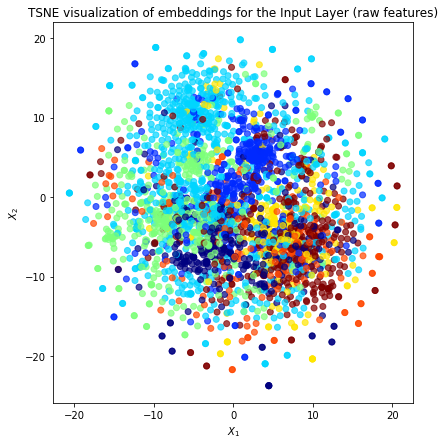

In [32]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=node_subjects.astype("category").cat.codes,
    cmap="jet",
    alpha=0.7,
)
ax.set(
    aspect="equal",
    xlabel="$X_1$",
    ylabel="$X_2$",
    title=f"{transform.__name__} visualization of embeddings for the Input Layer (raw features)",
)

In [1]:
node_subjects

NameError: name 'node_subjects' is not defined